<a href="https://colab.research.google.com/github/jkroman2/git-demo/blob/master/JasonK_Classification_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler

from pylab import rcParams
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report

import datetime
import nltk
from google.colab import files
from google.colab import auth
from google.colab import drive
drive.mount('gdrive')
from oauth2client.client import GoogleCredentials

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [0]:
zindi_train = pd.read_csv('gdrive/My Drive/Colab Notebooks/zindi_train.csv')

In [3]:
zindi_train.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [0]:
zindi_test = pd.read_csv('gdrive/My Drive/Colab Notebooks/zindi_test.csv')

In [5]:
zindi_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null object
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 11.7+ MB


In [0]:
fraud=zindi_train[zindi_train['FraudResult']==1]

In [7]:
print('fraud', round(zindi_train['FraudResult'].value_counts()[1]/len(zindi_train) * 100,2), '% of the dataset')

fraud 0.2 % of the dataset


In [8]:
print(zindi_train['FraudResult'].value_counts()[1], 'fraudulent transactions')

193 fraudulent transactions


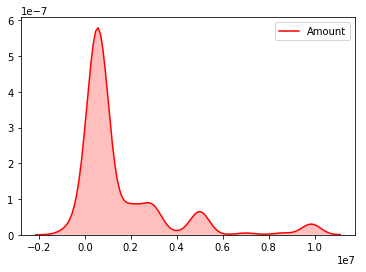

In [9]:
sns.kdeplot(fraud['Amount'],shade=True,color="red")

In [0]:
no_fraud=zindi_train[zindi_train['FraudResult']==0]

In [11]:
print('no_fraud', round(zindi_train['FraudResult'].value_counts()[0]/len(zindi_train) * 100,2), '% of the dataset')

no_fraud 99.8 % of the dataset


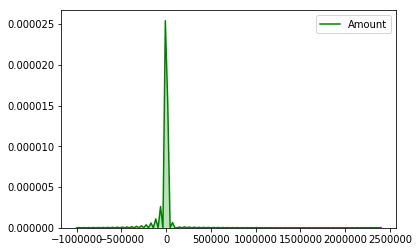

In [12]:
sns.kdeplot(no_fraud['Amount'],shade=True,color="green")

In [13]:
zindi_train = zindi_train.sample(frac=1)

# amount of fraud classes 193 rows.
fraud_df = zindi_train.loc[zindi_train['FraudResult'] == 1]
no_fraud_df = zindi_train.loc[zindi_train['FraudResult'] == 0][:193]

normal_df = pd.concat([fraud_df, no_fraud_df])

# Shuffle dataframe rows
shuffled_df = normal_df.sample(frac=1, random_state=42)

shuffled_df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
8742,TransactionId_107102,BatchId_44623,AccountId_678,SubscriptionId_2310,CustomerId_1020,UGX,256,ProviderId_6,ProductId_3,airtime,ChannelId_3,1000.0,1000,2018-11-26T12:32:24Z,2,0
20179,TransactionId_137124,BatchId_130477,AccountId_4841,SubscriptionId_3829,CustomerId_1987,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-100.0,100,2018-12-07T17:04:53Z,2,0
78670,TransactionId_139129,BatchId_127007,AccountId_572,SubscriptionId_2950,CustomerId_909,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,800000.0,800000,2019-01-30T18:47:53Z,2,1
53367,TransactionId_11960,BatchId_16942,AccountId_4249,SubscriptionId_4429,CustomerId_7343,UGX,256,ProviderId_4,ProductId_3,airtime,ChannelId_2,-25000.0,25000,2019-01-08T10:50:20Z,4,0
82341,TransactionId_68589,BatchId_125935,AccountId_572,SubscriptionId_2950,CustomerId_909,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,3000000.0,3000000,2019-02-01T17:29:20Z,0,1


Distribution of the FraudResult in the subsample dataset
1    0.5
0    0.5
Name: FraudResult, dtype: float64


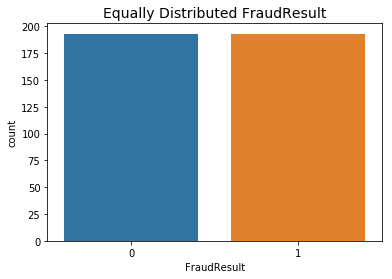

In [14]:
print('Distribution of the FraudResult in the subsample dataset')
print(shuffled_df['FraudResult'].value_counts()/len(shuffled_df))


sns.countplot('FraudResult', data=shuffled_df)
plt.title('Equally Distributed FraudResult', fontsize=14)
plt.show()

In [0]:
# Undersampling before cross validating
X = shuffled_df.drop('FraudResult', axis=1)
y = shuffled_df['FraudResult']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_test

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
65151,TransactionId_103318,BatchId_84561,AccountId_4841,SubscriptionId_3829,CustomerId_3912,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-10.0,10,2019-01-18T20:57:15Z,2
93991,TransactionId_79071,BatchId_54388,AccountId_127,SubscriptionId_2098,CustomerId_449,UGX,256,ProviderId_6,ProductId_3,airtime,ChannelId_3,10000.0,10000,2019-02-11T18:26:11Z,2
49032,TransactionId_130310,BatchId_82739,AccountId_4841,SubscriptionId_3829,CustomerId_4585,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-100.0,100,2019-01-02T09:56:49Z,2
51990,TransactionId_80428,BatchId_4591,AccountId_4407,SubscriptionId_3655,CustomerId_4864,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-01-07T06:41:16Z,2
72282,TransactionId_116080,BatchId_66087,AccountId_4841,SubscriptionId_3829,CustomerId_2816,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-87.5,88,2019-01-25T13:54:43Z,2
4911,TransactionId_66468,BatchId_89498,AccountId_4590,SubscriptionId_666,CustomerId_5054,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,500000.0,500000,2018-11-21T08:26:49Z,4
33173,TransactionId_96466,BatchId_134189,AccountId_4841,SubscriptionId_3829,CustomerId_647,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-100.0,100,2018-12-19T19:41:03Z,2
37616,TransactionId_93371,BatchId_124862,AccountId_2648,SubscriptionId_1311,CustomerId_3066,UGX,256,ProviderId_6,ProductId_3,airtime,ChannelId_3,1000.0,1000,2018-12-22T20:01:06Z,2
78041,TransactionId_34105,BatchId_27493,AccountId_4841,SubscriptionId_3829,CustomerId_1929,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-154.0,154,2019-01-30T08:12:07Z,2
78659,TransactionId_24271,BatchId_31797,AccountId_572,SubscriptionId_2950,CustomerId_909,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,800000.0,800000,2019-01-30T18:34:29Z,2


In [0]:
lr=LogisticRegression()

In [20]:
lr.fit(X_train, y_train)
training_score = cross_val_score(lr, X_train, y_train, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: ignored